# Original training

Train Tacotron2.

In [ ]:
!python train.py -m Tacotron2 -o output/ -lr 1e-3 --epochs 1500 -bs 80 --weight-decay 1e-6 --grad-clip-thresh 1.0 --cudnn-enabled --log-file output/nvlog.json --anneal-steps 500 1000 1500 --anneal-factor 0.1 --amp-run 

Train WaveGlow.

In [ ]:
!python train.py -m WaveGlow -o output/ -lr 1e-4 --epochs 1000 -bs 10 --segment-length  8000 --weight-decay 0 --grad-clip-thresh 65504.0 --epochs-per-checkpoint 50 --cudnn-enabled --cudnn-benchmark --log-file output/nvlog.json --amp-run

In [1]:

import os
import shutil
import glob
import re

from typing import List, Union

class util:
    
    @staticmethod
    def lmap(fn, iterable):
        return list(map(fn, iterable))

class Logger:
    
    def debug(*args):
        pass
    
    def info(*args):
        pass
    
    def trace(*args):
        pass
    
logger = Logger()

# Commons os.path functions, so we dont have to import os and io_util together.
exists = os.path.exists
dirname = os.path.dirname


def basename(path):
    if path.endswith('/'):
        path = path[:-1]
    return os.path.basename(path)


def delete_file(path):
    os.remove(path)


def move_file(src_path, dst_path):
    shutil.move(src_path, dst_path)


def copy_file(src_path, dst_path):
    if isinstance(dst_path, Directory):
        dst_path = str(dst_path)
    shutil.copy(src_path, dst_path)


def extension(filepath):
    """Just returns the second element of os.path.splitext.
    >>> extension('something.txt')
    '.txt'
    >>> extension('.txt')
    ''
    """
    _, ext = os.path.splitext(filepath)
    return ext


def has_extension(path: str):
    return len(extension(path)) > 0


def looks_like_a_file(path: str) -> bool:
    if not isinstance(path, str):
        return False
    if exists(path):
        return os.path.isfile(path)
    return has_extension(path)


def looks_like_a_dir(obj) -> bool:
    if isinstance(obj, Directory):
        return True
    elif not isinstance(obj, str):
        return False
    elif exists(obj):
        return os.path.isdir(obj)
    return not has_extension(obj)


def all_exists(*paths) -> bool:
    return all(exists(p) for p in paths)


def get_filepaths(dir_path, nested=True):
    """Returns list of [full] path_generator to FILES located within
    `dir_path` directory.
    """
    if not os.path.exists(dir_path):
        raise NotADirectoryError('`dir_path` does not exist: {}'.format(dir_path))
    if not nested:
        contents = [os.path.join(dir_path, c) for c in os.listdir(dir_path)]
        return [fp for fp in contents
                if os.path.isfile(fp) and is_valid_filepath(fp)]

    filepaths = []
    for root, dirs, files in os.walk(dir_path):
        files = [os.path.join(root, f) for f in files
                 if is_valid_filepath(os.path.join(root, f))]
        filepaths.extend(files)
    return filepaths


def is_valid_filepath(filepath) -> bool:
    filename = os.path.basename(filepath)
    isinvalid = filename.startswith('_') or filename.startswith('.')
    if isinvalid:
        logger.debug("Ignoring file: {}".format(filepath))
    return False if isinvalid else True


def num_files_nested(dir_path):
    if not os.path.exists(dir_path):
        raise NotADirectoryError('`dir_path` does not exist: {}'.format(dir_path))
    return len(get_filepaths(dir_path, nested=True))


def get_subdirs(dir_path, nested=False):
    """Returns list of [full] path_generator to dirs located within
    `dir_path` directory.
    """
    if not os.path.exists(dir_path):
        raise NotADirectoryError('`dir_path` does not exist: {}'.format(dir_path))
    if not nested:
        subdirs = [os.path.join(dir_path, name) for name in os.listdir(dir_path)]
        subdirs = [item for item in subdirs if os.path.isdir(item)]
        return subdirs
    dirpaths = []
    for root, dirs, files in os.walk(dir_path):
        logger.debug('Appending subdir: {}'.format(root))
        dirpaths.append(root)
    return dirpaths


def dirs_with_at_least_n(root_dir, nested=False, n=0):
    """Returns subdirectories of `root_dir` that have at least `n`
    [possibly nested] files within them.
    """
    subdirs = get_subdirs(root_dir, nested=nested)

    if n == 0:
        return subdirs

    filtered_subdirs = []
    for subdir in subdirs:
        num_files = num_files_nested(subdir)
        if num_files >= n:
            filtered_subdirs.append(subdir)
        else:
            logger.debug('Ignoring: {:<40} num files: {}'.format(
                basename(subdir), num_files))
    return filtered_subdirs


class Directory:
    """Handy wrapper around the above functions for fixed `dir_path`."""

    def __init__(self, path):
        if isinstance(path, Directory):
            path = path.path
        self._path = path

    @staticmethod
    def of_file(file_path):
        """Useful creator method when you want the directory of
        the current file, e.g.:
            d = Directory.of_file(__file__)
        instead of having to type:
            d = Directory(os.path.realpath(os.path.dirname(__file__)))

        Returns:
            Full path to directory containing `file_path`.
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f'File path not found: {file_path}')
        return Directory(os.path.realpath(os.path.dirname(file_path)))

    @property
    def path(self):
        if self._path.startswith('s3://'):
            return self._path
        elif re.search(r'^(/private)?/tmp', self._path):
            return os.path.realpath(self._path)
        elif self._path.startswith('/'):
            return self._path
        else:
            return os.path.realpath(self._path)

    @property
    def name(self):
        return basename(self.path)

    def create_if_not_exists(self):
        if not self.exists():
            self.create()

    def create(self):
        os.makedirs(self.path)

    def copy(self, destination_dir, overwrite=False):
        destination_dir = Directory(destination_dir)
        if destination_dir.exists():
            if overwrite:
                destination_dir.delete()
            else:
                raise ValueError(
                    f'destination_dir already exists: {destination_dir}')
        shutil.copytree(self.path, str(destination_dir))

    def parent_dir(self):
        return Directory(os.path.realpath(self.join(os.pardir)))

    def delete_contents(self, delete_subdirs=True):
        """
        Args:
            delete_subdirs: if True, also recursively deletes subdirectories.
                Otherwise, only delete files in immediate directory.
        """
        # Delete files immediately beneath self.
        util.lmap(lambda f: os.unlink(f), self.get_file_paths())
        # Delete subdirs if requested.
        if delete_subdirs:
            util.lmap(lambda d: shutil.rmtree(d.path), self.get_subdirs())

    def delete(self):
        shutil.rmtree(self.path)
        assert not self.exists()

    def empty(self):
        """
        Returns: True if there are no files or directories in self.
        """
        if not self.exists():
            self._warn_not_exists(self.empty)
            return True
        return all((util.is_empty(self.get_file_paths()),
                    util.is_empty(self.get_subdirs())))

    def exists(self):
        return os.path.exists(self.path)

    def has_files(self):
        if not self.exists():
            self._warn_not_exists(self.has_files)
            return False
        return len(self.get_file_paths(nested=False)) > 0

    def has_subdirs(self):
        if not self.exists():
            self._warn_not_exists(self.has_subdirs)
            return False
        return self.num_subdirs() > 0

    def has_subdir(self, name):
        if not self.exists():
            self._warn_not_exists(self.has_subdir, [name])
            return False
        return all((os.path.exists(self.join(name)),
                    os.path.isdir(self.join(name))))

    def has_file(self, name):
        if not self.exists():
            self._warn_not_exists(self.has_file, [name])
            return False
        return all((os.path.exists(self.join(name)),
                    os.path.isfile(self.join(name))))

    def get_file_path(self, name, require_exists=True):
        if require_exists and not self.has_file(name):
            raise FileNotFoundError(f'File {self.join(name)} not found.')
        return self.join(name)

    def get_file_paths(self,
                       nested=False,
                       sort=True,
                       filter_fn=None) -> List[str]:
        """
        Arguments:
            nested: (optional) whether to search arbitrarily deep for filepaths.
            sort: (optional) return paths sorted by name.
        """
        if not self.exists():
            self._warn_not_exists(
                self.get_file_paths, [nested, sort, filter_fn])
            return []
        paths = get_filepaths(dir_path=self.path, nested=nested)
        paths = self._filter_if_not_none(filter_fn, paths)
        if sort:
            paths = sorted(paths)
        return paths

    def get_relative_file_paths(self,
                                nested=False,
                                sort=True,
                                filter_fn=None) -> List[str]:
        """
        Arguments:
            nested: (optional) whether to search arbitrarily deep for filepaths.
            sort: (optional) return paths sorted by name.
        """
        if not self.exists():
            self._warn_not_exists(
                self.get_relative_file_paths, [nested, sort, filter_fn])
            return []
        paths = self.get_file_paths(nested=nested, sort=sort)
        for path in paths:
            assert path.startswith(self.path), \
                f'Expected {path} to start with {self.path}'
        prefix_len = len(self.path)
        paths = [path[prefix_len:].lstrip('/') for path in paths]
        paths = self._filter_if_not_none(filter_fn, paths)
        return paths

    def filenames(self,
                  nested=False,
                  sort=True,
                  filter_fn=None) -> List[str]:
        if not self.exists():
            self._warn_not_exists(
                self.filenames, [nested, sort, filter_fn])
            return []
        file_paths = self.get_file_paths(nested=nested, sort=sort)
        filenames = util.lmap(basename, file_paths)
        filenames = self._filter_if_not_none(filter_fn, filenames)
        return filenames

    @staticmethod
    def _filter_if_not_none(filter_fn, iterable):
        if filter_fn is None:
            return iterable
        else:
            return list(filter(filter_fn, iterable))

    def glob(self, pattern):
        return glob.glob(f'{self.path}/{pattern}')

    def subdir(self, *names, create=False, require_exists=True):
        if create:
            os.makedirs(self.join(*names), exist_ok=True)

        # Recursively check each subdir, so that it fails as early as possible
        # and the exception is actually useful. For example, if `foo` does not
        # exist, and we call subdir('foo', 'bar') we'd prefer to see
        # "foo does not exist" instead of "foo/bar does not exist".
        if require_exists and not self.has_subdir(names[0]):
            raise NotADirectoryError(self.join(names[0]))

        if len(names) == 1:     # Base case.
            return Directory(self.join(names[0]))
        else:                   # Inductive case.
            return Directory(self.join(names[0])).subdir(
                *names[1:], require_exists=require_exists)

    def get_subdirs(self, nested=False, min_total_files=0):
        if not self.exists():
            self._warn_not_exists(
                self.get_subdirs, [nested, min_total_files])
            return []
        raw_paths = dirs_with_at_least_n(
            self.path, nested=nested, n=min_total_files)
        return [Directory(p) for p in raw_paths]

    def num_subdirs(self, nested=False):
        if not self.exists():
            return 0
        return len(self.get_subdirs(nested=nested))

    def num_files(self, nested=False):
        if not self.exists():
            return 0
        return len(self.get_file_paths(nested=nested))

    def ls(self, nested=False):
        if not nested:
            return util.lmap(lambda d: d.path, self.get_subdirs()) + \
                   self.get_file_paths()
        else:
            return self.get_file_paths(nested=True)

    def join(self, *args):
        """Wraps os.path.join, where path begins with self.path.

        Returns:
            string path.
        """
        return os.path.join(self.path, *args)

    def _warn_not_exists(self, method, method_args=None):
        logger.warning(
            f'Tried calling '
            f'self.{functions.callee_string(method, method_args)} '
            f'but self={self} does not exist.')

    def __eq__(self, other):
        if not isinstance(other, Directory):
            return False
        return self.path == other.path

    def __repr__(self):
        return self.path




# Run Inference on Fine-Tuned Models

In [14]:
!mkdir -p output

In [32]:
%%writefile text.txt
William Shakespeare was an English poet, playwright and actor,widely regarded as the greatest writer in the English language and the world's greatest dramatist. He is often called England's national poet and the "Bard of Avon".

Overwriting text.txt


In [36]:
%%writefile text.txt
I am so excited to be a part of this presentation. 
I am the speaker from the LJSpeech dataset. 
Brandon McKinzie and Andrew Mendez are incredible students. 
Text to talking face is the best project ever. 
Hello Stanford University, I am a text to speech model.

Overwriting text.txt


### My Taco + My WaveGlow

In [2]:
output_dir = Directory('../output')
output_dir.ls()

['/root/Tacotron2/output/checkpoint_Tacotron2_0',
 '/root/Tacotron2/output/checkpoint_Tacotron2_100',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1000',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1100',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1200',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1300',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1400',
 '/root/Tacotron2/output/checkpoint_Tacotron2_1500',
 '/root/Tacotron2/output/checkpoint_Tacotron2_200',
 '/root/Tacotron2/output/checkpoint_Tacotron2_300',
 '/root/Tacotron2/output/checkpoint_Tacotron2_400',
 '/root/Tacotron2/output/checkpoint_Tacotron2_500',
 '/root/Tacotron2/output/checkpoint_Tacotron2_600',
 '/root/Tacotron2/output/checkpoint_Tacotron2_700',
 '/root/Tacotron2/output/checkpoint_Tacotron2_800',
 '/root/Tacotron2/output/checkpoint_Tacotron2_900',
 '/root/Tacotron2/output/checkpoint_WaveGlow_0',
 '/root/Tacotron2/output/checkpoint_WaveGlow_100',
 '/root/Tacotron2/output/checkpoint_WaveGlow_200',
 '/root/Tacot

In [37]:
!mkdir -p ../presentation_audio

In [38]:
%%bash

export CUDA_VISIBLE_DEVICES=7

# Pretrained paths/names:
# JoC_Tacotron2_FP32_PyT_20190306 
# JoC_WaveGlow_FP32_PyT_20190306
tacoDir="../output"
waveDir="../output"

tacoEpoch=1500
waveEpoch=950

# tacoPath="../output/Tacotron2/$tacoEpoch"
# wavePath="../output/WaveGlow/$waveEpoch"

tacoPath="../output/checkpoint_Tacotron2_$tacoEpoch"
wavePath="../output/checkpoint_WaveGlow_$waveEpoch"

echo "Running with tacoPath=${tacoPath}, wavePath=${wavePath}"
python ../inference.py \
    --tacotron2 $tacoPath --max-decoder-steps 2000 \
    --waveglow $wavePath  \
    -i text.txt \
    -o "../presentation_audio/taco_${tacoEpoch}_waveglow_${waveEpoch}" \
    --include-warmup \
    --amp-run
echo "Done!"

Running with tacoPath=../output/checkpoint_Tacotron2_1500, wavePath=../output/checkpoint_WaveGlow_950
:::NVLOGv0.2.2 Tacotron2_PyT 1575593699.051309109 (/root/Tacotron2/dllogger/logger.py:251) cpu_info: {"num": 80, "name": "Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz"}
:::NVLOGv0.2.2 Tacotron2_PyT 1575593699.064021349 (/root/Tacotron2/dllogger/logger.py:251) mem_info: {"ram": "128G"}
:::NVLOGv0.2.2 Tacotron2_PyT 1575593702.467555523 (/root/Tacotron2/dllogger/logger.py:251) gpu_info: {"driver_version": "410.79", "num": 8, "name": ["Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB"], "mem": ["32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB"]}
:::NVLOGv0.2.2 Tacotron2_PyT 1575593702.469003916 (/root/Tacotron2/dllogger/logger.py:251) args: {"input": "text.txt", "output": "../presentation_audio/taco_1500

In [39]:
import IPython.display as ipd

tacoEpoch=1500
waveEpoch=950

lines = text_lines('text.txt')

def yield_audio():
    i = 0
    for fpath in sorted(get_filepaths('../presentation_audio')):
        name = os.path.basename(fpath)
        if name.startswith(f'taco_{tacoEpoch}_waveglow_{waveEpoch}'):
            print('Playing:', name)
            print('Text:', lines[i])
            yield ipd.Audio(fpath, rate=22050)
            i += 1
            
audio_gen = yield_audio()

In [41]:
next(audio_gen)

Playing: taco_1500_waveglow_950_1.wav
Text: I am the speaker from the LJSpeech dataset.


------------------------------------

## Train from Scratch

In [241]:
%%writefile text.txt
I like dogs. I really like dogs.
Neither elevator was there.
The man intrusted with this privilege was often the inner gatesman,
All organisms have the same need of reproduction.

Overwriting text.txt


In [9]:
%%writefile text.txt
Neither elevator was there.
All organisms have the same need of reproduction.
There were no beds or bedding, no straw even.
four Presidents of the United States have been assassinated

Overwriting text.txt


In [10]:
# name ="my_voice_lj_only_taco700_wave250"
# name = 'my_voice400_output'
# name = 'combined_ljspeech250_myvoice400'
# name="first250_output"
name="my_voice_ljspeech_normhop256"
my_voice_dir = Directory(f'../{name}')
my_voice_dir.ls(nested=True)

['/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_0',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_1000',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_1200',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_1400',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_1600',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_1800',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_200',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_2000',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_2200',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_2400',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_2600',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_2800',
 '/root/Tacotron2/my_voice_ljspeech_normhop256/checkpoint_Tacotron2_3000',
 '/root/Tacotron2/my_voice_lj

In [11]:
%%bash

export CUDA_VISIBLE_DEVICES=7

# name="my_voice400_output"
# name="my_voice_lj_only_taco700_wave250"
# name="combined_ljspeech250_myvoice400"
# name="first250_output"
name="my_voice_ljspeech_normhop256"
tacoDir="../${name}"
# tacoDir="../output"
waveDir="../${name}"
# waveDir="../output"

tacoEpoch=4800
waveEpoch=4800

tacoPath="$tacoDir/checkpoint_Tacotron2_$tacoEpoch"
wavePath="$waveDir/checkpoint_WaveGlow_$waveEpoch"

echo "Running with tacoPath=${tacoPath}, wavePath=${wavePath}"
python ../inference.py \
    --tacotron2 $tacoPath --max-decoder-steps 2000 \
    --waveglow $wavePath  \
    -i text.txt \
    -o "../audio_samples/${name}_taco_${tacoEpoch}_waveglow_${waveEpoch}" \
    --include-warmup \
    --amp-run
echo "Done!"

Running with tacoPath=../my_voice_ljspeech_normhop256/checkpoint_Tacotron2_4800, wavePath=../my_voice_ljspeech_normhop256/checkpoint_WaveGlow_4800
:::NVLOGv0.2.2 Tacotron2_PyT 1575753757.175474882 (/root/Tacotron2/dllogger/logger.py:251) cpu_info: {"num": 80, "name": "Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz"}
:::NVLOGv0.2.2 Tacotron2_PyT 1575753757.190139532 (/root/Tacotron2/dllogger/logger.py:251) mem_info: {"ram": "128G"}
:::NVLOGv0.2.2 Tacotron2_PyT 1575753759.727064848 (/root/Tacotron2/dllogger/logger.py:251) gpu_info: {"driver_version": "410.79", "num": 8, "name": ["Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB", "Tesla V100-SXM2-32GB"], "mem": ["32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB", "32480 MiB"]}
:::NVLOGv0.2.2 Tacotron2_PyT 1575753759.728851318 (/root/Tacotron2/dllogger/logger.py:251) args: {"input": "text.txt

In [12]:
import IPython.display as ipd

tacoEpoch=4800
waveEpoch=4800

lines = text_lines('text.txt')

def yield_audio():
    i = 0
    for fpath in sorted(get_filepaths('../audio_samples')):
        _name = os.path.basename(fpath)
        if _name.startswith(f'{name}_taco_{tacoEpoch}_waveglow_{waveEpoch}'):
            print('Playing:', _name)
            print('Text:', lines[i])
            yield ipd.Audio(fpath, rate=22050)
            i += 1
            
audio_gen = yield_audio()

In [23]:
next(audio_gen)

Playing: my_voice_ljspeech_normhop256_taco_4800_waveglow_4800_1.wav
Text: All organisms have the same need of reproduction.


In [14]:
ipd.Audio('../audio_samples/my_voice400_taco_200_waveglow_300_0.wav', rate=22050)

In [52]:
import librosa
import torch
import librosa.display

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

n_group = 8
spect = np.load('/tmp/mel.npy')
print('S SHAPE', spect.shape)

spect = torch.tensor(spect).unfold(2, n_group, n_group)
print('A', 'S SHAPE', spect.shape)
spect = spect.permute(0, 2, 1, 3)
print('B', 'S SHAPE', spect.shape)
spect = spect.contiguous().view(spect.size(0), spect.size(1), -1) 
print('C', 'S SHAPE', spect.shape)
spect = spect.permute(0, 2, 1)

print('S SHAPE', spect.shape)
S = spect.numpy()[0]
print('S SHAPE', S.shape)

S_dB = librosa.power_to_db(S, ref=np.max)
print('S_DB', S_dB.shape)
librosa.display.specshow(S_dB[:128, :133], x_axis='time',y_axis='mel', sr=22050)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

S SHAPE (1, 80, 2000)
A S SHAPE torch.Size([1, 80, 250, 8])
B S SHAPE torch.Size([1, 250, 80, 8])
C S SHAPE torch.Size([1, 250, 640])
S SHAPE torch.Size([1, 640, 250])
S SHAPE (640, 250)
S_DB (640, 250)


IndexError: cannot do a non-empty take from an empty axes.

<Figure size 720x288 with 0 Axes>

------------------------

# Loss Plotting

In [6]:
import json 
from typing import * 
def save_lines(lines: Iterable[Any], path: str):
    with open(path, 'w+') as f:
        for line in lines:
            f.write(f'{line}\n')


def text_lines(text_path):
    with open(text_path) as f:
        lines = [line.strip() for line in f]
    return lines


def load_json(path) -> dict:
    with open(path) as f:
        return json.load(f)


In [44]:
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import FormatStrFormatter

jtplot.style(theme='grade3', ticks=True, grid=True, context='paper', gridlines='--')

def plot_losses(json_obj):
    avg_loss = json_obj['epoch']['train_epoch_avg_loss']
    val_loss = json_obj['epoch']['val_iter_loss']
    
    avg_loss = util.lmap(abs, avg_loss)
    val_loss = util.lmap(abs, val_loss)
    smallest_val = min(avg_loss + val_loss)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 8))
    
    ax = plt.subplot(1, 2, 1)
    plt.scatter(
        np.arange(len(avg_loss)), avg_loss, 
        label='avg_train_loss',
        c='blue', 
        marker=mpl.markers.MarkerStyle(marker='D', fillstyle='none'),
        alpha=0.5)
    plt.scatter(
        np.arange(len(val_loss)), val_loss, 
        marker=mpl.markers.MarkerStyle(marker='o', fillstyle='none'),
        label='val_iter_loss',
        c='red', 
        alpha=0.5)
    plt.yscale('log')
    
    _, hi = plt.ylim()
    plt.ylim(smallest_val / 2, hi)
    
    
    plt.grid(b=True, which='minor', color='gray', linestyle='-.', alpha=0.2)
    plt.tick_params(axis='y', which='minor')
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.tight_layout()
   

In [45]:
!mkdir -p ../figs

In [46]:
def plot_train_val_loss(output_dir, plot_taco=True, plot_wave=True):
    if plot_taco:
        taco_json = load_json(output_dir.join('tacotron2.nvlog.json'))
        taco_json['epoch'].keys()
        plot_losses(taco_json)
        plt.title('Tacotron2 Losses')
        plt.savefig(f'../figs/{output_dir.name}_tacotron2.png')
        plt.show()

    if plot_wave:
        wave_json = load_json(output_dir.join('waveglow.nvlog.json'))
        plot_losses(wave_json)
        plt.title('WaveGlow Losses')
        plt.savefig(f'../figs/{output_dir.name}_waveglow.png')
        plt.show()

Used dogs filelist for validation.

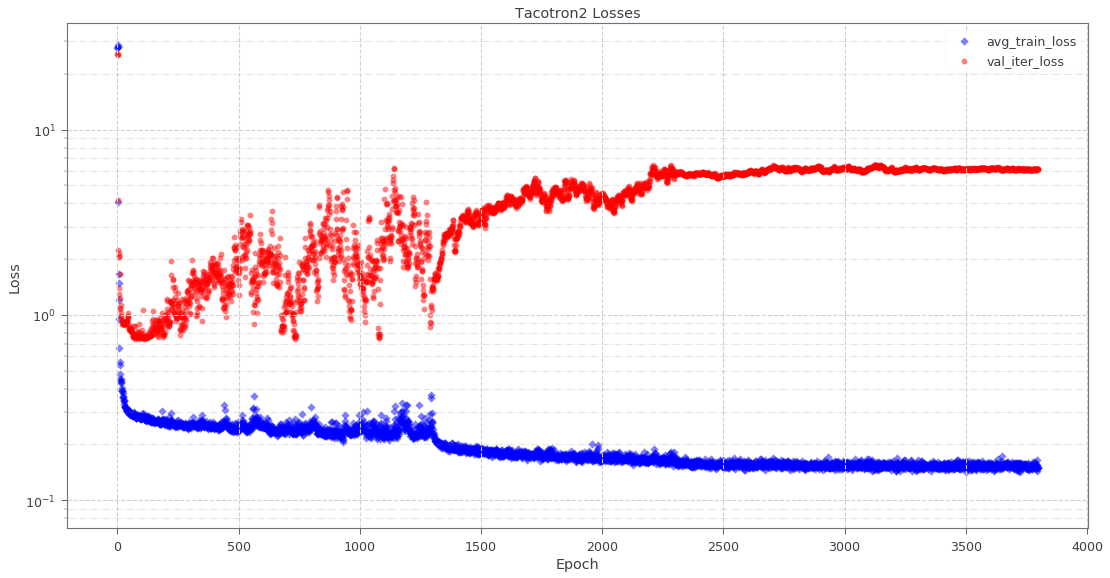

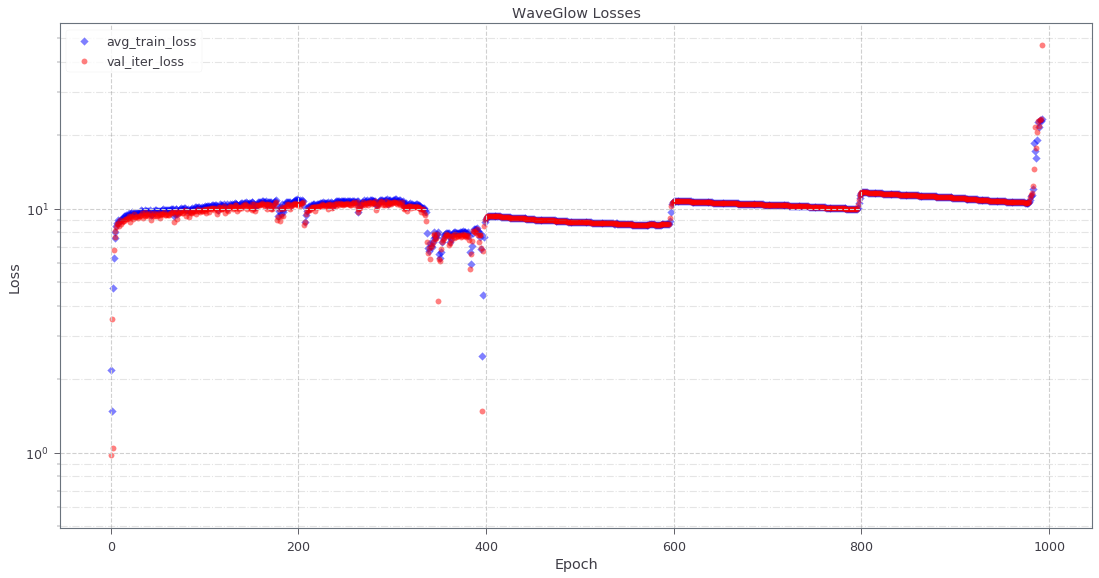

In [47]:
plot_train_val_loss(Directory('../my_voice_lj_only_taco700_wave250'))

Used subset of lj-only filelist (of my voice) for validation.

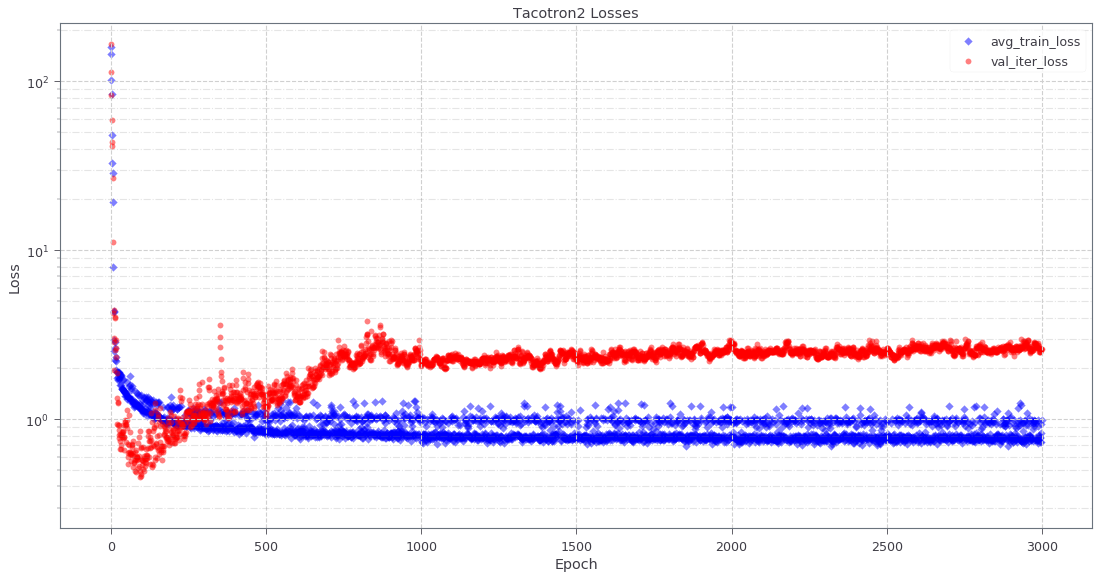

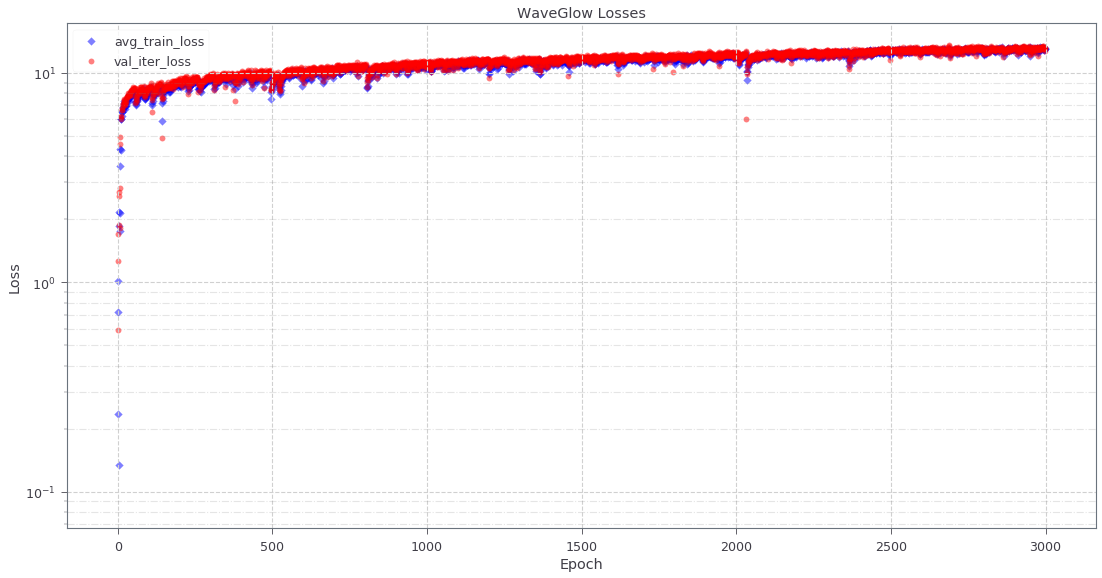

In [48]:
plot_train_val_loss(Directory('../my_voice_dogs_output'))

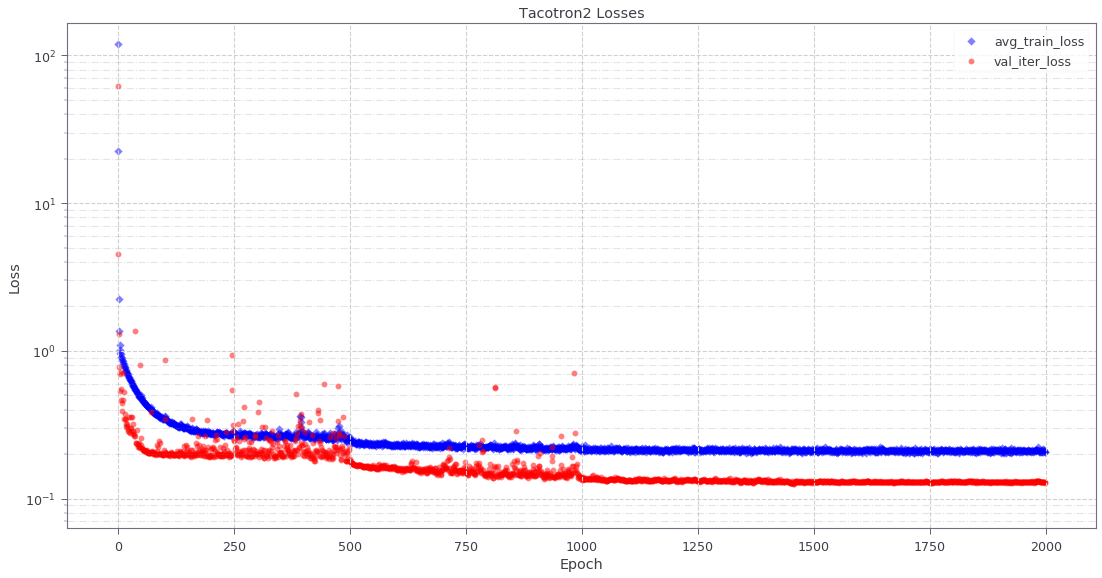

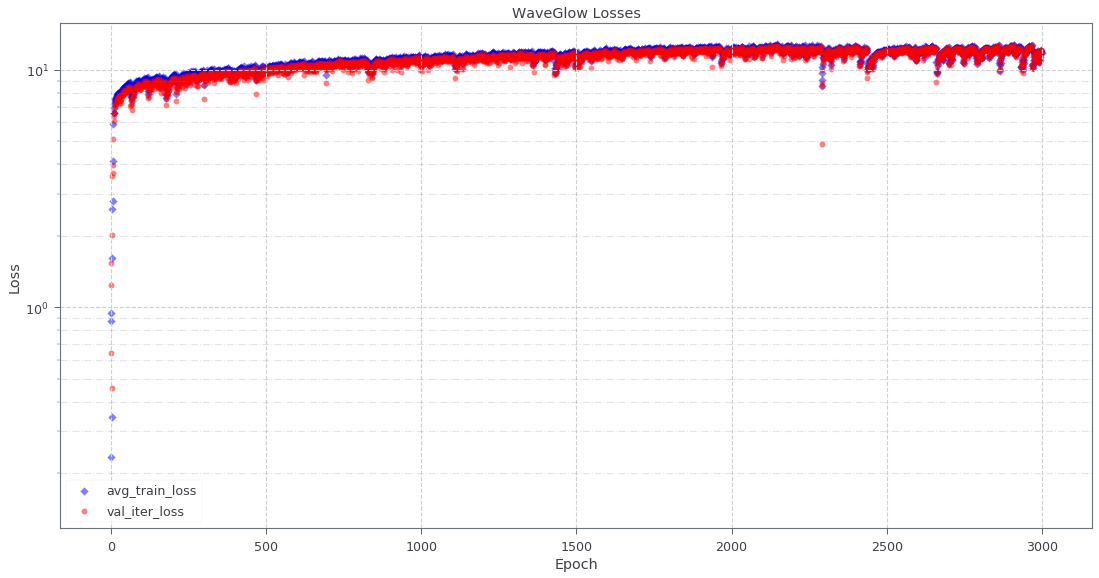

In [49]:
plot_train_val_loss(Directory('../my_voice400_output'))

Train on my voice ljspeech[20:], validate on some i_like_dogs, i_really_like_dogs, and my voice ljspeech[:20]

Sets norm=True, hop_length=256 when doing fix_sr_and_trim in prep stage.

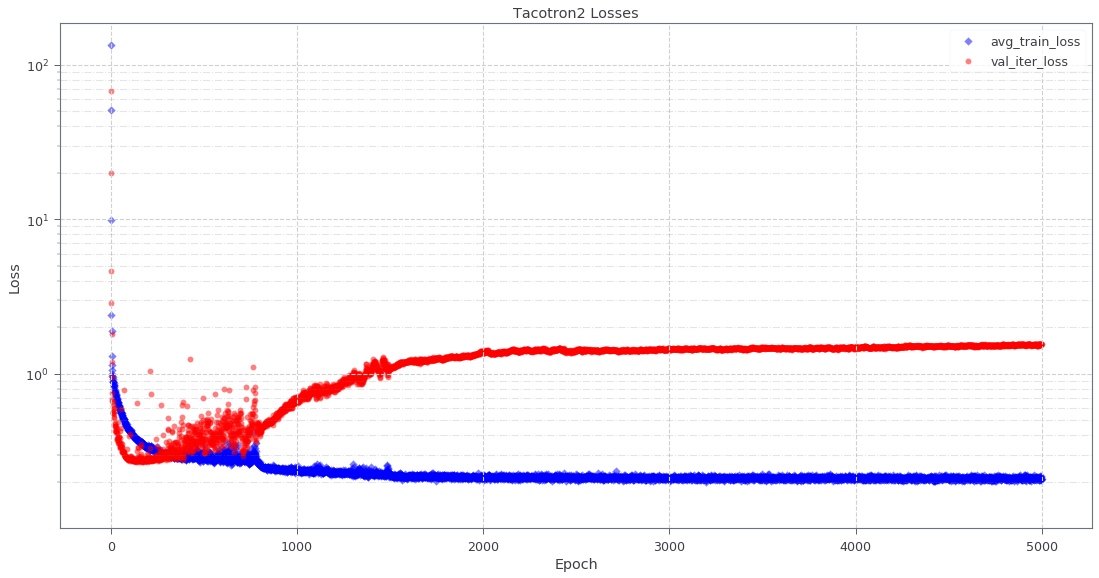

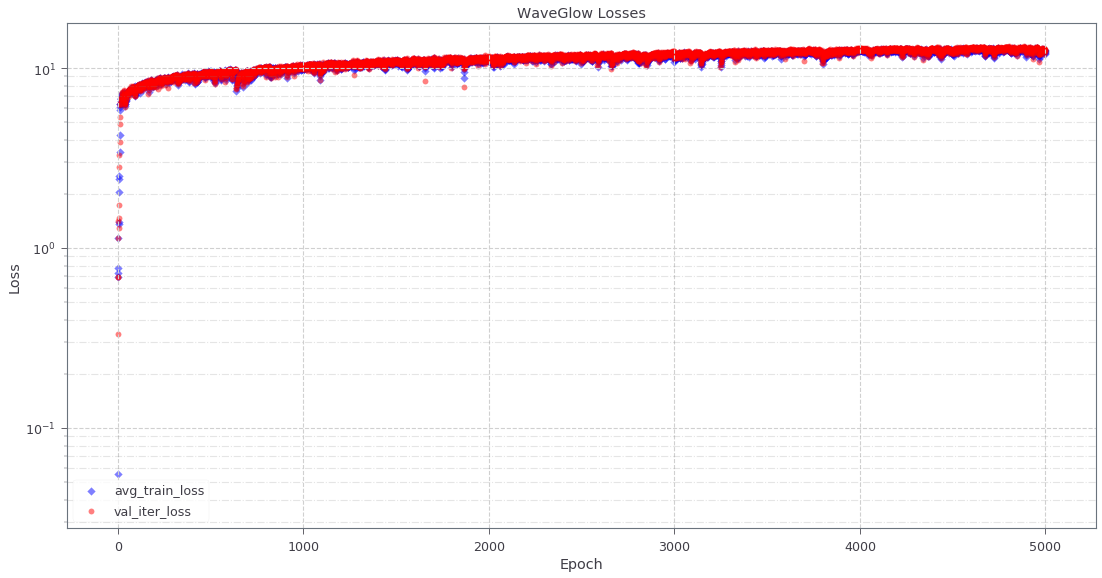

In [50]:
plot_train_val_loss(Directory('../my_voice_ljspeech_normhop256'))

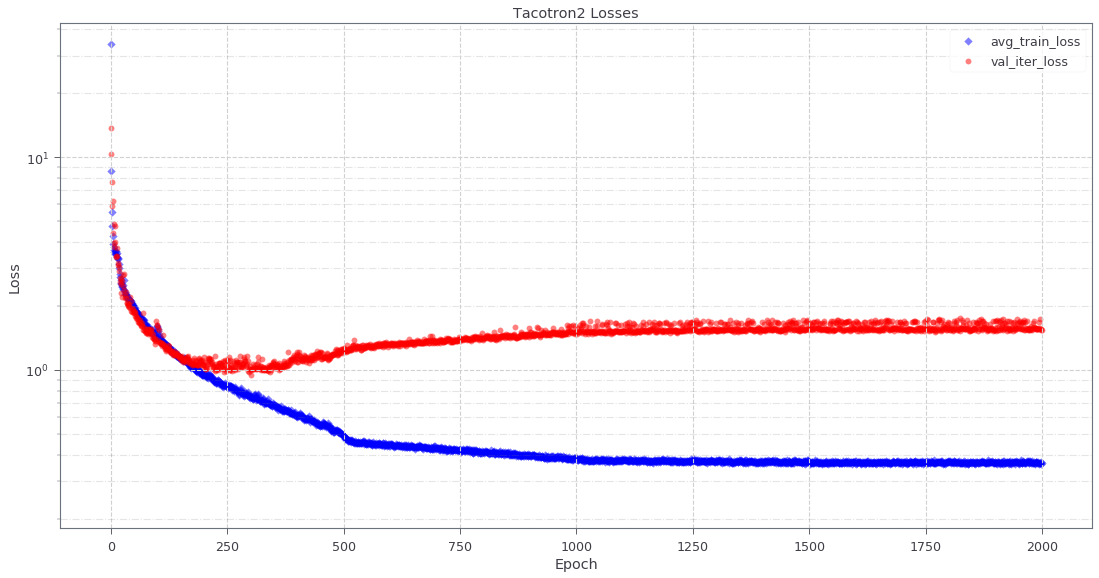

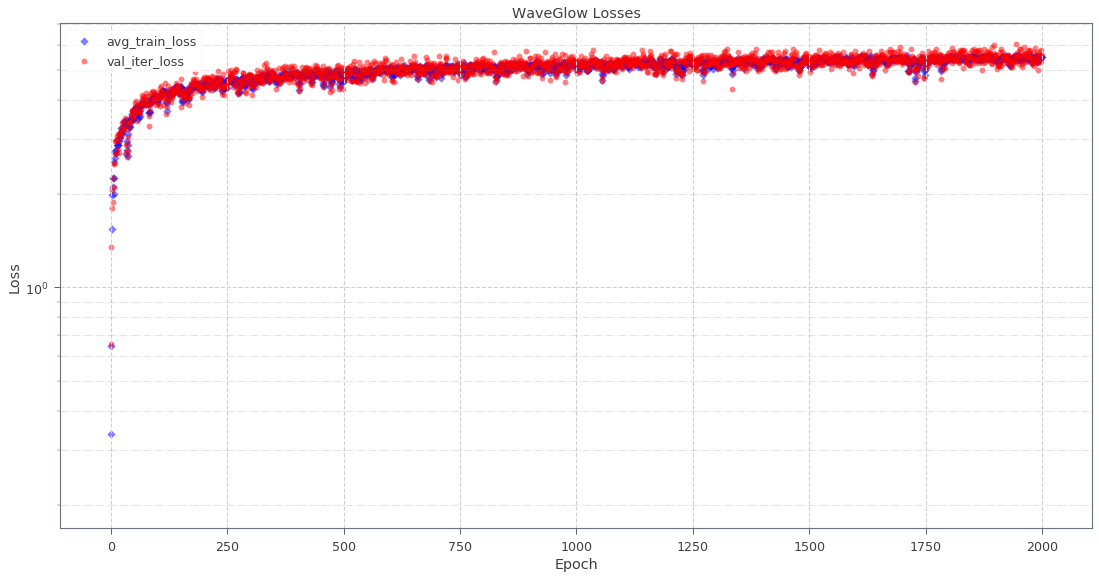

In [51]:
plot_train_val_loss(Directory('../first250_output'))

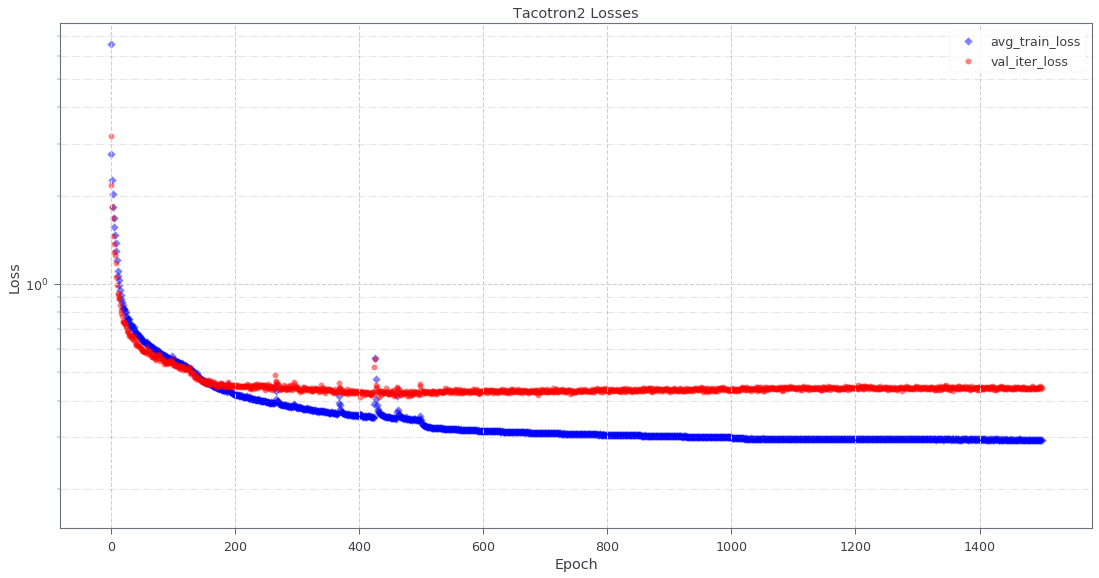

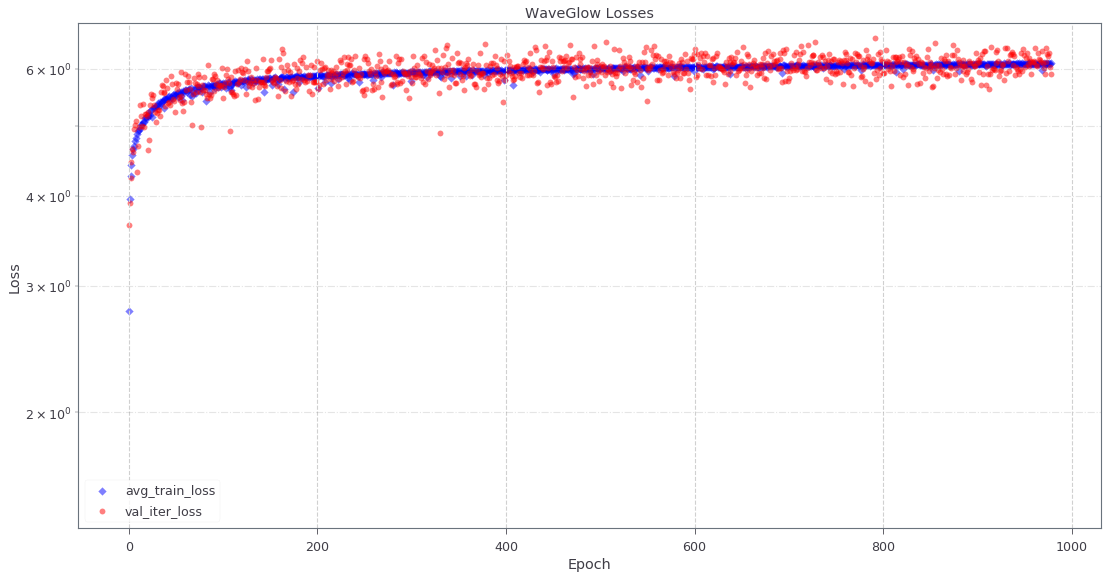

In [52]:
plot_train_val_loss(Directory('../output'))

## First250 logs from prev cluster

In [114]:
my_voice_dir = Directory('/root/old_cluster_outputs/first250_output')
my_voice_dir.ls()

['/root/old_cluster_outputs/first250_output/WaveGlow',
 '/root/old_cluster_outputs/first250_output/Tacotron2',
 '/root/old_cluster_outputs/first250_output/tacotron2.nvlog.json',
 '/root/old_cluster_outputs/first250_output/waveglow.nvlog.json']

In [116]:
taco_json = load_json(my_voice_dir.join('tacotron2.nvlog.json'))
taco_json['epoch'].keys()
plot_losses(taco_json)
plt.title('Tacotron2 Losses')
plt.show()

JSONDecodeError: Expecting value: line 36766 column 16 (char 1069382)

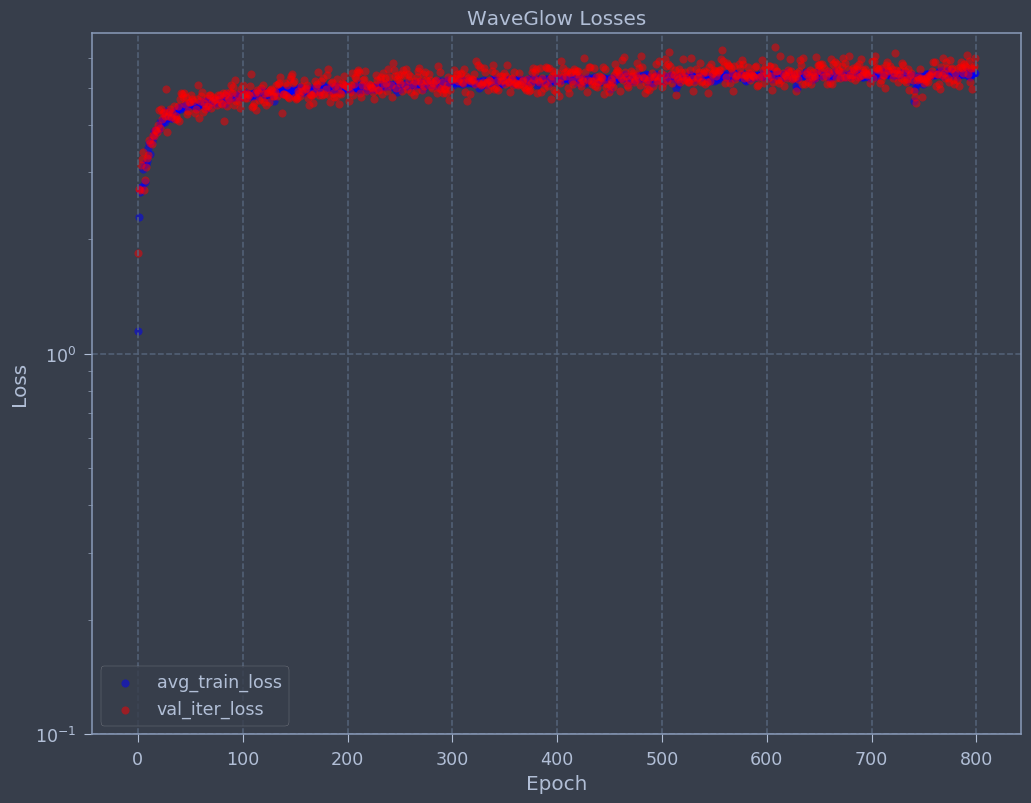

In [117]:
wave_json = load_json(my_voice_dir.join('waveglow.nvlog.json'))
plot_losses(wave_json)
plt.title('WaveGlow Losses')
plt.show()

# Graveyard

In [ ]:
import shutil

def move_file(src_path, dst_path):
    shutil.move(src_path, dst_path)


def copy_file(src_path, dst_path):
    shutil.copy(src_path, dst_path)


wav_files = ['my_voice/wavs/i_like_dogs_0.wav|I like dogs.']
mel_files = ['my_voice/mels/i_like_dogs_0.pt|I like dogs.']
for i in range(1, 100):
    copy_file(ojoin(wavs_dir, 'i_like_dogs_0.wav'), ojoin(wavs_dir, f'i_like_dogs_{i}.wav'))
    wav_files.append(f'my_voice/wavs/i_like_dogs_{i}.wav|I like dogs.')
    
for i in range(1, 100):
    ildirld = 'i_like_dogs_i_really_like_dogs'
    copy_file(ojoin(wavs_dir, f'{ildirld}_0.wav'), ojoin(wavs_dir, f'{ildirld}_{i}.wav'))
    wav_files.append(f'my_voice/wavs/{ildirld}_{i}.wav|I like dogs. I really like dogs.')
    
for i in range(1, 100):
    ildirld = 'ildirld'
    copy_file(ojoin(wavs_dir, f'{ildirld}_0.wav'), ojoin(wavs_dir, f'{ildirld}_{i}.wav'))
    wav_files.append(f'my_voice/wavs/{ildirld}_{i}.wav|I like dogs. I really like dogs.')

with open(wavs_train_list_path, 'w+') as f:
    f.write('\n'.join(wav_files))
    
# with open(mels_train_list_path, 'w+') as f:
#     f.write('\n'.join(mel_files))